# PHYS381 Final report: non-linear least squares

Assume that we have some sequence of measurements at times $t_i$
$$ y_i = y(t_i)$$

and some presumed model of the relationship

$$ \tilde y = f(t; p) $$

expressed in terms of the independent variable and model parameters $p$.

For example, if our model is a straight line

$$ y = a x + b $$

then there are two parameters which we can express as a vector

$$ \vec p = \begin{bmatrix}
           a \\
           b 
         \end{bmatrix}
$$

How can we find the parameters which provide the ``best'' fit to the data?

This requires that we select some quantitative measures of the fit quality.  Ideally, we would like the difference $\delta$ between model and data 

$$ \delta_i = y_i -  \tilde y_i$$

to be equal to zero for each observation.  Failing that, we might try to make all the differences as small as possible.  This can be tricky, because improving the fit for one point will often make it worse for some others.

A general measure of the distance is

$$ \sum | \delta_i |^d $$

where for $d=2$ we obtain a quantity that is usually called chi-squared

$$ \chi^2 = \sum | y_i - \tilde y_i(p_1,\ldots,p_K) |^2 $$

The best fit is assumed to correspond to minima in $\chi^2$ with respect to the model parameters

$$ \frac{\partial \chi^2}{\partial p_k} = 2 \sum \left( y_i - \tilde y_i \right) \frac{\partial \tilde y_i}{\partial p_k} $$

which in turn depends on how the model changes with respect to the parameters.  Note that this will in general require that we solve $K$ coupled non-linear equations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Linearity of *parameters*

A straight line

$$y= m x + b$$

is linear in all model parameters.  So is a quadratic

$$y = c_0 + c_1 x + c_2 x^2$

but not an exponential

$$y = \exp(-d x)$$

because $y$ has a nonlinear dependence on $d$.

## Linear example

Non-linear fitting (aka "optimization") techniques can be used for both linear and non-linear models.

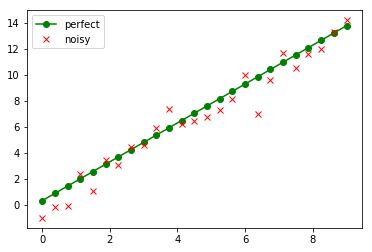

In [2]:
def linear_model(x, param, noise=0):
    """ for input slope and intercept return $y= m x + b$
    
    """
    slope, intercept = param
    result = slope*x + intercept
    if noise != 0:
        result += np.random.normal(loc=0, scale=noise, size=x.shape )
    return result

x = np.linspace(0, 9.0, 25)
y_perfect = linear_model( x, (1.5, 0.3), noise=0)
y_noisy = linear_model( x, (1.5, 0.3), noise=1)
plt.plot(x, y_perfect, 'go-', label='perfect')
plt.plot(x, y_noisy, 'rx', label='noisy')
plt.legend(loc=0)

## reduced chi-squared

The standard definition of $\chi^2$

$$ \chi^2 = \sum_{i=1}^N | y_i - \tilde y_i(p_1,\ldots,p_K) |^2 $$

gives values that scale with the number of points.  In other words, if we double the number of data points then we might expect $\chi^2$ to be about twice as large. 

It is convenient to introduce a quantity called "reduced" chi-squared

$$ \chi^2_N = \frac{\chi^2}{N} $$

simply by dividing by the number of data points.  Note that this does not change the location of minima or maxima, and thus has no effect on the fitting results.

Strictly speaking, we would like to define $\chi^2$ more generally by scaling according to the uncertainty in each observation

$$ \sum \frac{\mathrm{expected} - \mathrm{observed}}{\mathrm{uncertainty}} $$

For a "good" model we should expect that the difference between expected (model) and observed (data) values should be on the order of the uncertainty.  This would produce reduced chi-squared values of order 1.

If we do not have reliable estimates of the uncertainty then we can proceed by just setting it to some constant (ie 1).  Note that this does not change the location of minima or maxima, and thus has no effect on the fitting results.

In [3]:
def chi_squared(expected, observed, uncertainty=1):
    result = (observed-expected) / uncertainty
    return np.sum(result**2)

print( 'chi-squared: ',chi_squared(y_perfect, y_noisy) )

chi-squared:  25.268737853288755


In [4]:
def chi_squared_reduced(expected, observed, uncertainty=1):
    result = (observed-expected) / uncertainty
    return np.sum(result**2) / len(observed)

print('reduced chi-squared: ', chi_squared_reduced(y_perfect, y_noisy) )

reduced chi-squared:  1.0107495141315501


## 1-d optimization

A simple approach to finding the optimal parameters is to vary one of them over some range of values while keeping the others constant.  We might expect that corresponding values for $\chi^2$ should have a minimum at the "true" parameter value.  This is not necessarily the case, unless all of the other parameters are already set to their true values.

best fit chi2  1.0412328196586636e-06 near intercept  0.3010204081632653


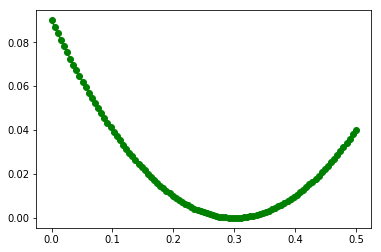

In [5]:
slope0, intercept0 = 1.5, 0.3
y_perfect = linear_model( x, (slope0, intercept0), noise=0)
intercept_sequence = np.linspace(0.0, 0.5, 99)

chi2 = []
for intercept in intercept_sequence:
    y_model = linear_model( x, (slope0, intercept))
    chi2.append( chi_squared_reduced(y_perfect, y_model))

wmin = np.argmin( chi2 )    
print( 'best fit chi2 ', chi2[wmin], 'near intercept ', intercept_sequence[wmin])
plt.plot(intercept_sequence, chi2, 'go-')    

## 2-d optimization

If we consider a model with two parameters, then the goal is to find a minimum point in a $\chi^2$ surface.  If we need to take $N$ steps to solve a 1-d problem then in general a 2-d problem will require $N^2$ steps.

59 50
best fit chi2  2.603082049146659e-05 near intercept  0.3010204081632653 and slope  1.5


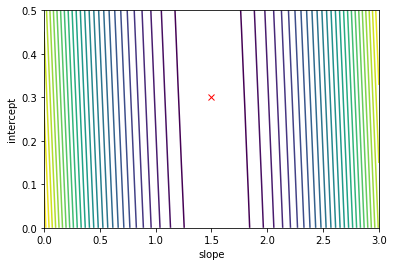

In [6]:
slope0, intercept0 = 1.5, 0.3
y_perfect = linear_model( x, (slope0, intercept0), noise=0)

intercept_sequence = np.linspace(0.0, 0.5, 99)
slope_sequence = np.linspace(0, 3.0, 101)

chi2 = -np.ones( [len(intercept_sequence), len(slope_sequence)])
for indx,intercept in enumerate(intercept_sequence):
    for jndx,slope in enumerate(slope_sequence):
        y_model = linear_model( x, (slope, intercept) )
        chi2[indx,jndx] =  chi_squared(y_perfect, y_model)

xx, yy = np.meshgrid(slope_sequence, intercept_sequence)
   
wmin = np.argmin(chi2)    
(x0, y0) = np.unravel_index(wmin, chi2.shape) 
print( x0,y0 )
print( 'best fit chi2 ', chi2[x0,y0], 'near intercept ', intercept_sequence[x0], 'and slope ', slope_sequence[y0])

plt.contour( xx, yy, chi2 , 29)    
plt.xlabel('slope')
plt.ylabel('intercept')
plt.plot( slope_sequence[y0], intercept_sequence[x0], 'rx')

## N-d 
https://en.wikipedia.org/wiki/Curse_of_dimensionality

For a model with three parameters the problem is to find a minimum point in a 3-d volume.

In general, we will need to calculate $\chi^2$ a very large number of times

$$ N^d $$



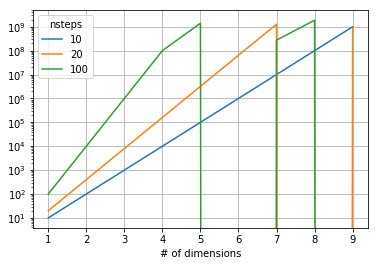

In [7]:
ndims = np.arange(1,10)
nsteps = [10, 20, 100]
for n in nsteps:
    plt.plot(ndims, n**ndims, label=str(n))
plt.legend(loc=0, title='nsteps')
plt.xlabel('# of dimensions')
plt.yscale('log')
plt.grid('on')

## Example

The scipy.optimize software package provides a wide variety of tools for non-linear optimization.

In order to use most of these tools we need to provide a function which takes as input some set of parameters and returns as output some measure of fit quality (ie. $\chi^2$).  This is the same basic idea that we encountered in root-finding, numerical integration, and ODEs.

In this case the utility function will usually need to know some additional information which should not be passed through as paramters.  Most optimization methods will have a general "args" argument which can be used for this purpose.  Alternatively, we could use nested fucnctions, lambda functions, or global variables.

In [8]:
import scipy.optimize

zxypath = []

def fit_func(param, *args):
    """ Utility function for non-linear optimization.
    
    Note: zxypath is not required for fitting.  It is used here
    just to keep track of what steps are taken to find the solution.
    """
    global zxypath
    slope, intercept = param
    x, y_data = args
    y_model = linear_model(x, (slope, intercept))
    residuals = y_model - y_data
    chi2 = np.sum( residuals**2 )
    zxypath.append( (chi2, *param) )
    return chi2

slope, intercept = 1.5, 0.3
y_perfect = linear_model( x, (slope, intercept), noise=0)
y_noisy = linear_model( x, (slope, intercept), noise=0.0)

param_guess = [1.0, 0.25]
best_fit_param = scipy.optimize.minimize(fit_func, param_guess, (x, y_noisy), method='Nelder-Mead' )
print(best_fit_param)

 final_simplex: (array([[1.49999486, 0.30001628],
       [1.50001122, 0.29995915],
       [1.50001004, 0.29992682]]), array([5.98630098e-09, 2.53172190e-08, 3.80376452e-08]))
           fun: 5.986300983714727e-09
       message: 'Optimization terminated successfully.'
          nfev: 78
           nit: 41
        status: 0
       success: True
             x: array([1.49999486, 0.30001628])


In [9]:
print(type(y_noisy))

<class 'numpy.ndarray'>


If we use an initial guess that is in the neighborhood of the true values, then the optimizer gets a result that is correct to at least 4 decimal places.  This requires 78 evaluations of the utility function.



In [10]:
param_guess = [-1.0, -0.25]
best_fit_param = scipy.optimize.minimize(fit_func, param_guess, (x, y_noisy), method='Nelder-Mead' )
print(best_fit_param)

 final_simplex: (array([[1.49999428, 0.30001977],
       [1.50001078, 0.29996152],
       [1.49999692, 0.2999743 ]]), array([6.88018669e-09, 2.37382271e-08, 4.08156307e-08]))
           fun: 6.880186687476258e-09
       message: 'Optimization terminated successfully.'
          nfev: 111
           nit: 58
        status: 0
       success: True
             x: array([1.49999428, 0.30001977])


Starting with a very different initial guess, we still converge to the correct result, but it takes 111 function evaluations.

When dealing with a new problem it is usually a good idea to make plots of $\chi^2$ in 1-d or 2-d.  It may also be helpful to examine the path to convergence as follow:

[177.953125   1.         0.25    ]
[144.66015625   1.05         0.25      ]
[176.51953125   1.           0.2625    ]
[143.3671875   1.05        0.2625   ]
[127.47460938   1.075        0.26875   ]
[100.63867188   1.125        0.25625   ]
[70.64208984  1.1875      0.253125  ]
[58.79443359  1.2125      0.271875  ]
[30.11706543  1.29375     0.2828125 ]
[6.77526855 1.40625    0.2671875 ]
[3.04464722 1.571875   0.26640625]
[21.70675659  1.678125    0.29609375]
[141.36315918   1.95625      0.2796875 ]
[1.30953979 1.459375   0.28203125]
[16.49630737  1.353125    0.25234375]
...
[4.29627340e-08 1.49998471e+00 3.00071631e-01]
[2.41700446e-07 1.49999937e+00 3.00101126e-01]
[4.08156307e-08 1.49999692e+00 2.99974303e-01]
[1.22790254e-07 1.50002299e+00 2.99864196e-01]
[6.88018669e-09 1.49999428e+00 3.00019772e-01]


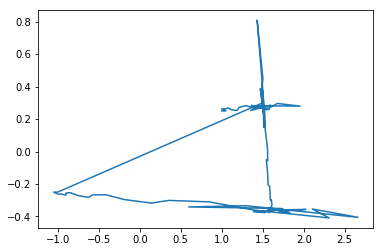

In [11]:
zxy = np.array(zxypath).T
#print( zxypath.shape )

# look at the first 15 points
for line in zxy[:,0:15].T:
    print(line)
    #print( "{:14.4f} {:14.4f} {:14.f4}".format(line) ) 

# skip a bunch of points in the middle    
print( '...' )

# look at the last 5 points
for line in zxy[:,-5:].T:
    print( line )#"{:14.4f} {:14.4f} {:14.f4}".format(line) )
    
# try a different way to visualize    
plt.plot(zxy[1,:], zxy[2,:])    

### Task 1: Get data from ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt and briefly summarize key properties and features.  Consider using one or more plots.

### Task 2: Use tools from scipy.optimize to fit the following models

#### linear: $$ y = p t + q $$ for the entire data set
#### periodic: $$ y = A cos(b t + c) $$ just for the 12 months in year 2000
#### combined: $$ y = p t + q + A cos(b t + c) $$ for the entire data set

Compare and discuss your results.

### Task 3: Try to find a model which provides a better fit to the entire data set.  Discuss your choice and results.